In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate some data
mu_0 = -5
sigma_0 = 3
mu_1 = 3
sigma_1 = 2

n_clips = 5000
n_pos = 20

# generate data
scores = np.zeros(n_clips)
labels = np.zeros(n_clips)
scores[:n_pos] = np.random.normal(mu_1, sigma_1, n_pos)
labels[:n_pos] = 1
scores[n_pos:] = np.random.normal(mu_0, sigma_0, n_clips - n_pos)
labels[n_pos:] = 0

# make a labeling weighting. Try 1/rank
df = pd.DataFrame({'score': scores, 'label': labels})
df = df.sort_values("score", ascending=False)
df["weighting"] = 1/(1 + np.arange(len(df)))

# shuffle them just to remove any ordering
df = df.sample(frac=1)

# ensure labels are integers
df["label"] = df["label"].astype(int)

n_labeled = 10

# sample according to the weighting
labeled = df.sample(n_labeled, weights="weighting")
unlabeled = df.drop(labeled.index)

# normalize the labeled weights
labeled["weighting"] = labeled["weighting"] / labeled["weighting"].sum()

# make the data dictionary
data = {'N_labeled': len(labeled), 
        'N_unlabeled': len(unlabeled), 
        'scores_labeled': labeled['score'].values, 
        'scores_unlabeled': unlabeled['score'].values,
        'sampling_weight': labeled["weighting"].values,
        'labels': labeled["label"].values}

# make the data


Number of positives in labeled data: 1
proportion of positives in labeled data: 0.1
proportion of positives in all data: 0.004


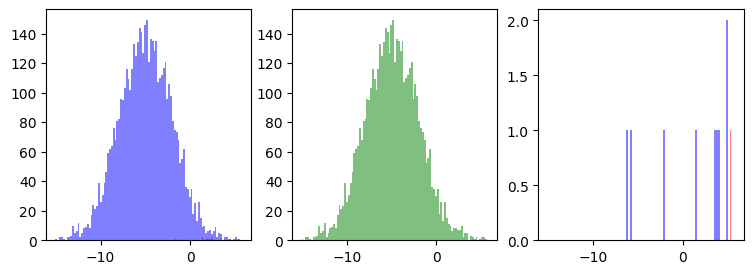

In [33]:
# plot the histogram of scores
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
pos = df[df['label'] == 1]
neg = df[df['label'] == 0]
ax[0].hist(pos['score'], bins=100, alpha=0.5, label='pos', color='red')
ax[0].hist(neg['score'], bins=100, alpha=0.5, label='neg', color='blue')
ax[1].hist(df['score'], bins=100, alpha=0.5, label='all', color='green')
ax[2].hist(labeled[labeled["label"] ==1]['score'], bins=10, alpha=0.5, label='labeled', color='red')
ax[2].hist(labeled[labeled["label"] ==0]['score'], bins=50, alpha=0.5, label='unlabeled', color='blue')
print(f"Number of positives in labeled data: {np.sum(labeled['label'])}")
print(f"proportion of positives in labeled data: {np.mean(labeled['label'])}")
print(f"proportion of positives in all data: {np.mean(df['label'])}")

In [34]:
#import cmdstanpy and use the stan model
import cmdstanpy
file = "weighted_sample_gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [35]:
# fit the model
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=250)

10:13:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:13:54 - cmdstanpy - INFO - CmdStan done processing.


In [36]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()

In [37]:
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-14185.80000,0.142949,2.015060,-14189.900000,-14185.30000,-14183.40000,198.70600,20.03490,1.00918
mu[1],-5.09025,0.002077,0.041625,-5.161890,-5.09038,-5.02184,401.79200,40.51140,1.00386
mu[2],1.89054,0.046552,0.962845,0.322918,1.96595,3.17877,427.79400,43.13310,1.01304
sigma[1],2.77714,0.001505,0.033065,2.722730,2.77625,2.83124,482.42400,48.64120,1.00541
sigma[2],1.75999,0.047515,0.707776,0.907664,1.66255,2.91613,221.88300,22.37180,1.01905
theta,0.00730,0.000220,0.004040,0.001910,0.00667,0.01509,345.01979,34.78723,1.00559
n_pos_pred,41.83100,1.258550,22.157290,12.000000,38.00000,81.00000,309.95269,31.25153,1.00853
